# Word Level Federated Text Generation with Stack Overflow using Randomly Initialized or Pretrained Word Embeddings and Optional Model Pretraining
- 03-07-20
- Runs on GCP and local Ubuntu 16.04

**About:**

This notebook loads the Stack Overflow data available through `tff.simulation.datasets` and trains an LSTM model with Federared Averaging by following the Federated Learning for Text Generation [example notebook](https://github.com/tensorflow/federated/blob/master/docs/tutorials/federated_learning_for_text_generation.ipynb).  The embedding layer is initialized with one of the following options by setting the `EMBEDDING_LAYER` parameter:
- [GloVe](https://nlp.stanford.edu/projects/glove/) ([license here](https://www.opendatacommons.org/licenses/pddl/1.0/))
- [FastText](https://fasttext.cc/docs/en/english-vectors.html) ([license here](https://creativecommons.org/licenses/by-sa/3.0/))
- [GPT-2](https://openai.com/blog/better-language-models/) ([license here](https://github.com/huggingface/transformers/blob/master/LICENSE))
- [Randomly initialized embeddings](https://www.tensorflow.org/api_docs/python/tf/random_uniform_initializer)  

After downloading the GloVe or FastText embeddings, place the embedding files at the top level of the repository in directories called `word_embedding/glove` and `word_embedding/fasttext` respectively.  GPT-2 embeddings are downloaded by running the notebook which makes a call to `src/embeddings.py` to download the embeddings from [huggingface](https://github.com/huggingface/transformers).  

**Code from Tensorflow Federated:**

- This notebook prepares the Stack Overflow dataset for word level language modeling using this [module](https://github.com/tensorflow/federated/blob/master/tensorflow_federated/python/research/baselines/stackoverflow/dataset.py
).
- The metrics for model training come from this [module](https://github.com/tensorflow/federated/blob/master/tensorflow_federated/python/research/baselines/stackoverflow/metrics.py). 


**Data and Model References:**
- [TFF Stack Overflow `load_data`](https://www.tensorflow.org/federated/api_docs/python/tff/simulation/datasets/stackoverflow/load_data)
- [TFF text generation tutorial](https://github.com/tensorflow/federated/blob/master/docs/tutorials/federated_learning_for_text_generation.ipynb)
- [Google TFF team research baselines for Stack Overflow](https://github.com/tensorflow/federated/tree/master/tensorflow_federated/python/research/baselines/stackoverflow)
- [Tensorflow text generation tutorial](https://www.tensorflow.org/tutorials/text/text_generation)

**Environment Setup References:**
- [Installing Tensorflow for GPU](https://www.tensorflow.org/install/gpu)
- [Install CUDA 10.0 and cuDNN v7.4.2 on Ubuntu 16.04](https://gist.github.com/matheustguimaraes/43e0b65aa534db4df2918f835b9b361d)
- [Tensorflow build configs](https://www.tensorflow.org/install/source#tested_build_configurations)
- [Using jupyter notebooks with a virtual environment](https://anbasile.github.io/programming/2017/06/25/jupyter-venv/)

### Imports

In [1]:
import nest_asyncio
nest_asyncio.apply()

In [2]:
import os, sys, io
sys.path.append(os.path.dirname(os.getcwd()))

In [3]:
import collections
import functools
import six
import time
import string
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_federated as tff

In [4]:
from src import dataset, metrics, embeddings, model, validation, federated, generate_text, transfer_learning

### Set Some Parameters for Preprocessing the Data and Training the Model

In [5]:
VOCAB_SIZE = 10000
BATCH_SIZE = 16
CLIENTS_EPOCHS_PER_ROUND = 1
MAX_SEQ_LENGTH = 20
MAX_ELEMENTS_PER_USER = 5000
CENTRALIZED_TRAIN = False
SHUFFLE_BUFFER_SIZE = 1000
NUM_VALIDATION_EXAMPLES = 20000
NUM_TEST_EXAMPLES = 100

NUM_PRETRAINING_ROUNDS = 2
NUM_ROUNDS = 10
NUM_TRAIN_CLIENTS = 10

EMBEDDING_DIM = 100
RNN_UNITS = 128

EMBEDDING_LAYER = 'pca_fasttext'
SAV = 'embedding_layer_results/{}_{}_{}_{}_{}/'.format(NUM_PRETRAINING_ROUNDS,
                                                       EMBEDDING_LAYER, 
                                                       EMBEDDING_DIM, 
                                                       RNN_UNITS, 
                                                       EMBEDDING_DIM)

In [6]:
extended_vocab_size = VOCAB_SIZE + len(dataset.get_special_tokens(VOCAB_SIZE))

### Create the Output Directory if Nonexistent

In [7]:
if not os.path.exists(SAV):
    os.makedirs(SAV)

### Load and Preprocess Word Level Datasets

In [8]:
train_data, val_data, test_data = dataset.construct_word_level_datasets(
    vocab_size=VOCAB_SIZE,
    batch_size=BATCH_SIZE,
    client_epochs_per_round=CLIENTS_EPOCHS_PER_ROUND,
    max_seq_len=MAX_SEQ_LENGTH,
    max_elements_per_user=MAX_ELEMENTS_PER_USER,
    centralized_train=CENTRALIZED_TRAIN,
    shuffle_buffer_size=SHUFFLE_BUFFER_SIZE,
    num_validation_examples=NUM_VALIDATION_EXAMPLES,
    num_test_examples=NUM_TEST_EXAMPLES)

/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


### Retrieve the Fine Tunining Dataset Vocab

In [9]:
vocab = dataset.get_vocab(vocab_size=VOCAB_SIZE)

### Pretrain with a Different Text Corpus by First Reading in the Text Data

In [10]:
if NUM_PRETRAINING_ROUNDS > 0:
    
    # Load and preprocess the shakespeare dataset
    X, Y, vocab_sp = transfer_learning.load_and_preprocess_shakespeare(VOCAB_SIZE)
    
    # Build an embedding layer given the desired layer type
    embedding_matrix = embeddings.build_embedding_layer(embedding_type=EMBEDDING_LAYER,
                                                        embedding_dim=EMBEDDING_DIM,
                                                        vocab=vocab_sp,
                                                        base_path='../word_embeddings/')
    
    # Create the model to pretrain
    keras_model_sp = model.build_model(extended_vocab_size=extended_vocab_size,
                                   embedding_dim=EMBEDDING_DIM,
                                   embedding_matrix=embedding_matrix,
                                   rnn_units=RNN_UNITS)
    
    # Compile the model
    evaluation_metrics_sp = validation.get_metrics(VOCAB_SIZE)
    model.compile_model(keras_model_sp, evaluation_metrics_sp)
    
    # Fit the model
    history = keras_model_sp.fit(X, Y, epochs=NUM_PRETRAINING_ROUNDS)

/home/joel_stremmel/Documents/dev_gear/git/fl-text-models/src/embeddings.py:104: missing_words_warning: 4233 words set to default random initialization
  .format(missing), missing_words_warning)


Train on 904064 samples
Epoch 1/2
904064/904064 [==============================] - 318s 351us/sample - loss: 5.0554 - num_tokens: 705808.0000 - num_tokens_no_oov: 705808.0000 - num_batches: 28252.0000 - num_examples: 904064.0000 - accuracy: 0.0738 - accuracy_no_oov: 0.0738 - accuracy_no_oov_no_eos: 0.0738
Epoch 2/2
904064/904064 [==============================] - 317s 350us/sample - loss: 4.7742 - num_tokens: 705808.0000 - num_tokens_no_oov: 705808.0000 - num_batches: 28252.0000 - num_examples: 904064.0000 - accuracy: 0.0902 - accuracy_no_oov: 0.0902 - accuracy_no_oov_no_eos: 0.0902


### Create Embedding Matrix for the Federated Model
If the model has been pretrained, this layer will be replaced during the transfer learning step.

In [11]:
embedding_matrix = embeddings.build_embedding_layer(embedding_type=EMBEDDING_LAYER,
                                                    embedding_dim=EMBEDDING_DIM,
                                                    vocab=vocab,
                                                    base_path='../word_embeddings/')

/home/joel_stremmel/Documents/dev_gear/git/fl-text-models/src/embeddings.py:104: missing_words_warning: 926 words set to default random initialization
  .format(missing), missing_words_warning)


### Create TFF Version of the Model to be Trained with Federated Averaging
- TFF uses a sample batch so it knows the types and shapes that your model expects.
- The model function then builds and compiles the model and creates a TFF version to be trained.

In [12]:
sample_batch = tf.nest.map_structure(lambda x: x.numpy(), next(iter(val_data)))

/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


### Initialize Train and Validation Model Trackers to be Used Below

In [13]:
evaluation_metric_names = ['loss',
                           'num_tokens',
                           'num_tokens_no_oov',
                           'num_batches',
                           'num_examples',
                           'accuracy',
                           'accuracy_no_oov',
                           'accuracy_no_oov_no_oes']

train_metrics_tracker = validation.model_history_tracker(metric_names=evaluation_metric_names)
val_metrics_tracker = validation.model_history_tracker(metric_names=evaluation_metric_names)

### Create an Iterative Process

In [14]:
iterative_process = (
      tff.learning.federated_averaging.build_federated_averaging_process(
          model_fn=lambda : model.model_fn(extended_vocab_size=extended_vocab_size,
                                           embedding_dim=EMBEDDING_DIM,
                                           embedding_matrix=embedding_matrix,
                                           rnn_units=RNN_UNITS,
                                           vocab_size=VOCAB_SIZE,
                                           sample_batch=sample_batch),
          server_optimizer_fn=federated.server_optimizer_fn,
          client_weight_fn=federated.client_weight_fn))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/learning/federated_averaging.py:242: UserWarning: tff.learning.build_federated_averaging_process will start requiring a new argument 'client_optimizer_fn'. Specify the local client optimizer here rather than building a ttf.learning.TrainableModel
  warnings.warn('tff.learning.build_federated_averaging_process will start '


### Apply Transfer Learning if the Model has been Pretrained

In [15]:
if NUM_PRETRAINING_ROUNDS > 0:
    server_state = transfer_learning.learn_from_pretrained_model(iterative_process, keras_model_sp)
else:
    server_state = iterative_process.initialize()

### Train Model Across Many Randomly Sampled Clients with Federated Averaging

In [16]:
start_time = time.time()
for round_num in tqdm(range(0, NUM_ROUNDS)):

    # Examine validation metrics
    print('Evaluating before round #{} on {} examples.'.format(round_num, NUM_VALIDATION_EXAMPLES))
    validation.keras_evaluate(state=server_state,
                              val_dataset=val_data,
                              extended_vocab_size=extended_vocab_size,
                              vocab_size=VOCAB_SIZE,
                              embedding_dim=EMBEDDING_DIM,
                              embedding_matrix=embedding_matrix,
                              rnn_units=RNN_UNITS,
                              metrics_tracker=val_metrics_tracker,
                              checkpoint_dir=SAV)

    # Sample train clients to create a train dataset
    print('\nSampling {} new clients.'.format(NUM_TRAIN_CLIENTS))
    train_clients = federated.get_sample_clients(dataset=train_data, num_clients=NUM_TRAIN_CLIENTS)
    train_datasets = [train_data.create_tf_dataset_for_client(client) for client in train_clients]

    # Apply federated training round
    server_state, server_metrics = iterative_process.next(server_state, train_datasets)

    # Examine training metrics
    print('Round: {}'.format(round_num))
    print('   Loss: {:.8f}'.format(server_metrics.loss))
    print('   num_batches: {}'.format(server_metrics.num_batches))
    print('   num_examples: {}'.format(server_metrics.num_examples))
    print('   num_tokens: {}'.format(server_metrics.num_tokens))
    print('   num_tokens_no_oov: {}'.format(server_metrics.num_tokens_no_oov))
    print('   accuracy: {:.5f}'.format(server_metrics.accuracy))
    print('   accuracy_no_oov: {:.5f}'.format(server_metrics.accuracy_no_oov))

    # Add train metrics to tracker
    train_metrics_tracker.add_metrics_by_name('loss', server_metrics.loss)
    train_metrics_tracker.add_metrics_by_name('accuracy', server_metrics.accuracy)
    train_metrics_tracker.add_metrics_by_name('num_examples', server_metrics.num_examples)
    train_metrics_tracker.add_metrics_by_name('num_tokens', server_metrics.num_tokens)
    train_metrics_tracker.add_metrics_by_name('num_tokens_no_oov', server_metrics.num_tokens_no_oov)
        
    # Save loss and accuracy from train and validation sets
    np.save(SAV + 'train_loss.npy', train_metrics_tracker.get_metrics_by_name('loss'))
    np.save(SAV + 'val_loss.npy', val_metrics_tracker.get_metrics_by_name('loss'))
    np.save(SAV + 'train_accuracy.npy', train_metrics_tracker.get_metrics_by_name('accuracy'))
    np.save(SAV + 'val_accuracy.npy', val_metrics_tracker.get_metrics_by_name('accuracy'))
        
    # Save train sample stats
    np.save(SAV + 'num_examples.npy', train_metrics_tracker.get_metrics_by_name('num_examples'))
    np.save(SAV + 'num_tokens.npy', train_metrics_tracker.get_metrics_by_name('num_tokens'))
    np.save(SAV + 'num_tokens_no_oov.npy', train_metrics_tracker.get_metrics_by_name('num_tokens_no_oov'))
    
    # Write time since start of training
    with open(SAV + 'train_time.txt', 'a+') as f: 
        f.write('{}\n'.format(time.time() - start_time))

  0%|          | 0/10 [00:00<?, ?it/s]

Evaluating before round #0 on 20000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    200/Unknown - 22s 110ms/step - loss: 6.2703 - num_tokens: 265904.0000 - num_tokens_no_oov: 257821.0000 - num_batches: 200.0000 - num_examples: 20000.0000 - accuracy: 0.0122 - accuracy_no_oov: 0.0126 - accuracy_no_oov_no_eos: 0.0134
Saving model weights at iteration: 0

Sampling 10 new clients.


 10%|█         | 1/10 [00:44<06:40, 44.53s/it]

Round: 0
   Loss: 5.85024166
   num_batches: 227
   num_examples: 3577
   num_tokens: 45869
   num_tokens_no_oov: 44661
   accuracy: 0.00903
   accuracy_no_oov: 0.00927
Evaluating before round #1 on 20000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    200/Unknown - 22s 112ms/step - loss: 6.0558 - num_tokens: 258878.0000 - num_tokens_no_oov: 250713.0000 - num_batches: 200.0000 - num_examples: 20000.0000 - accuracy: 0.0126 - accuracy_no_oov: 0.0130 - accuracy_no_oov_no_eos: 0.0138
Saving model weights at iteration: 1

Sampling 10 new clients.


 20%|██        | 2/10 [01:26<05:50, 43.87s/it]

Round: 1
   Loss: 5.79871464
   num_batches: 177
   num_examples: 2762
   num_tokens: 34835
   num_tokens_no_oov: 34048
   accuracy: 0.00873
   accuracy_no_oov: 0.00893
Evaluating before round #2 on 20000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    200/Unknown - 22s 111ms/step - loss: 6.0626 - num_tokens: 262588.0000 - num_tokens_no_oov: 254115.0000 - num_batches: 200.0000 - num_examples: 20000.0000 - accuracy: 0.0122 - accuracy_no_oov: 0.0126 - accuracy_no_oov_no_eos: 0.0134
Sampling 10 new clients.


 30%|███       | 3/10 [02:12<05:09, 44.27s/it]

Round: 2
   Loss: 5.97838402
   num_batches: 272
   num_examples: 4298
   num_tokens: 60720
   num_tokens_no_oov: 59210
   accuracy: 0.01593
   accuracy_no_oov: 0.01633
Evaluating before round #3 on 20000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    200/Unknown - 22s 111ms/step - loss: 6.0521 - num_tokens: 264858.0000 - num_tokens_no_oov: 256531.0000 - num_batches: 200.0000 - num_examples: 20000.0000 - accuracy: 0.0121 - accuracy_no_oov: 0.0125 - accuracy_no_oov_no_eos: 0.0133- 18s 115ms/step - loss: 6.0078 - num_tokens: 200814.0000 - num_tokens_no_oov: 194361.0000 - num_batches: 153.0000 - num_examples: 15300.0000 - accuracy: 0.0123 - accuracy
Sampling 10 new clients.


 40%|████      | 4/10 [03:02<04:36, 46.15s/it]

Round: 3
   Loss: 5.43162632
   num_batches: 385
   num_examples: 6092
   num_tokens: 90350
   num_tokens_no_oov: 87892
   accuracy: 0.05103
   accuracy_no_oov: 0.04965
Evaluating before round #4 on 20000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    200/Unknown - 22s 111ms/step - loss: 5.9635 - num_tokens: 263229.0000 - num_tokens_no_oov: 254811.0000 - num_batches: 200.0000 - num_examples: 20000.0000 - accuracy: 0.0125 - accuracy_no_oov: 0.0129 - accuracy_no_oov_no_eos: 0.0137
Sampling 10 new clients.


 50%|█████     | 5/10 [03:43<03:42, 44.58s/it]

Round: 4
   Loss: 5.55080938
   num_batches: 149
   num_examples: 2305
   num_tokens: 28594
   num_tokens_no_oov: 27801
   accuracy: 0.00808
   accuracy_no_oov: 0.00831
Evaluating before round #5 on 20000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    200/Unknown - 22s 112ms/step - loss: 5.9585 - num_tokens: 265030.0000 - num_tokens_no_oov: 256061.0000 - num_batches: 200.0000 - num_examples: 20000.0000 - accuracy: 0.0121 - accuracy_no_oov: 0.0125 - accuracy_no_oov_no_eos: 0.0133
Sampling 10 new clients.


 60%|██████    | 6/10 [04:24<02:53, 43.41s/it]

Round: 5
   Loss: 5.65002155
   num_batches: 149
   num_examples: 2346
   num_tokens: 29439
   num_tokens_no_oov: 28593
   accuracy: 0.00914
   accuracy_no_oov: 0.00941
Evaluating before round #6 on 20000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    200/Unknown - 22s 111ms/step - loss: 5.8757 - num_tokens: 265453.0000 - num_tokens_no_oov: 257145.0000 - num_batches: 200.0000 - num_examples: 20000.0000 - accuracy: 0.0120 - accuracy_no_oov: 0.0124 - accuracy_no_oov_no_eos: 0.0132- 12s 119ms/step - loss: 5.9411 - num_tokens: 138071.0000 - num_tokens_no_oov: 133599.0000 - num_batches: 103.0000 - num_
Sampling 10 new clients.


 70%|███████   | 7/10 [05:17<02:19, 46.49s/it]

Round: 6
   Loss: 4.57430601
   num_batches: 449
   num_examples: 7089
   num_tokens: 96427
   num_tokens_no_oov: 94481
   accuracy: 0.08579
   accuracy_no_oov: 0.08713
Evaluating before round #7 on 20000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    200/Unknown - 23s 113ms/step - loss: 5.7811 - num_tokens: 261836.0000 - num_tokens_no_oov: 253004.0000 - num_batches: 200.0000 - num_examples: 20000.0000 - accuracy: 0.0120 - accuracy_no_oov: 0.0124 - accuracy_no_oov_no_eos: 0.0132
Sampling 10 new clients.


 80%|████████  | 8/10 [06:03<01:32, 46.21s/it]

Round: 7
   Loss: 5.31456327
   num_batches: 277
   num_examples: 4366
   num_tokens: 58029
   num_tokens_no_oov: 56138
   accuracy: 0.01885
   accuracy_no_oov: 0.01945
Evaluating before round #8 on 20000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    200/Unknown - 22s 111ms/step - loss: 5.8842 - num_tokens: 273030.0000 - num_tokens_no_oov: 265258.0000 - num_batches: 200.0000 - num_examples: 20000.0000 - accuracy: 0.0121 - accuracy_no_oov: 0.0125 - accuracy_no_oov_no_eos: 0.0132
Sampling 10 new clients.


 90%|█████████ | 9/10 [06:50<00:46, 46.53s/it]

Round: 8
   Loss: 5.47910023
   num_batches: 311
   num_examples: 4916
   num_tokens: 72632
   num_tokens_no_oov: 69988
   accuracy: 0.04268
   accuracy_no_oov: 0.04098
Evaluating before round #9 on 20000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    200/Unknown - 23s 117ms/step - loss: 5.7368 - num_tokens: 264761.0000 - num_tokens_no_oov: 255806.0000 - num_batches: 200.0000 - num_examples: 20000.0000 - accuracy: 0.0114 - accuracy_no_oov: 0.0118 - accuracy_no_oov_no_eos: 0.0125- 15s 121ms/step - loss: 5.7400 - num_tokens: 159927.0000 - num_tokens_no_oov: 154458.0000 - num_batches: 121.0000 - num_examples: 12100.00
Sampling 10 new clients.


100%|██████████| 10/10 [07:37<00:00, 45.78s/it]

Round: 9
   Loss: 5.21794033
   num_batches: 245
   num_examples: 3845
   num_tokens: 51602
   num_tokens_no_oov: 50382
   accuracy: 0.02701
   accuracy_no_oov: 0.02741


### Set Plot Title Based on Training Configuration 

In [17]:
round_config = 'Clients: {}, Max Elements per Client: {}, Max Seq Len: {}, Num Rounds: {}'.format(
    NUM_TRAIN_CLIENTS, MAX_ELEMENTS_PER_USER, MAX_SEQ_LENGTH, NUM_ROUNDS)

### Plot Train and Validation Loss

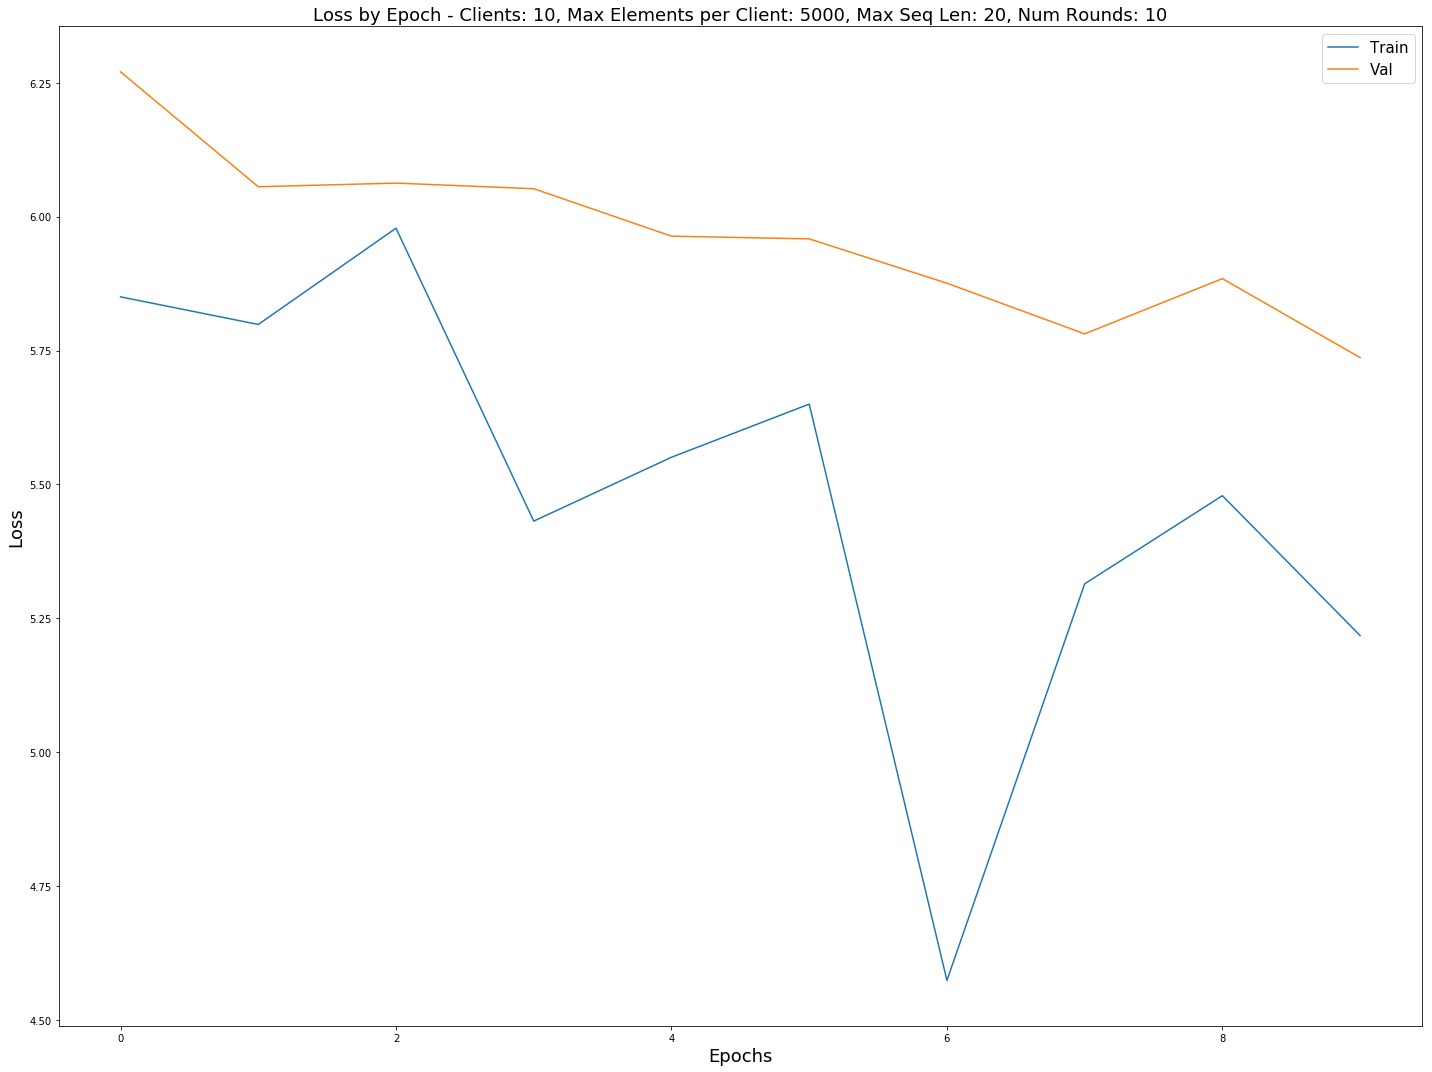

In [18]:
fig, ax = plt.subplots(figsize=(20, 15))
x_axis = range(0, NUM_ROUNDS)
ax.plot(x_axis, train_metrics_tracker.get_metrics_by_name('loss'), label='Train')
ax.plot(x_axis, val_metrics_tracker.get_metrics_by_name('loss'), label='Val')
ax.legend(loc='best', prop={'size': 15})
plt.title('Loss by Epoch - {}'.format(round_config), fontsize=18)
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.tight_layout()
plt.savefig(SAV + 'Loss by Epoch.png')
plt.show()

### Plot Train and Validation Accuracy

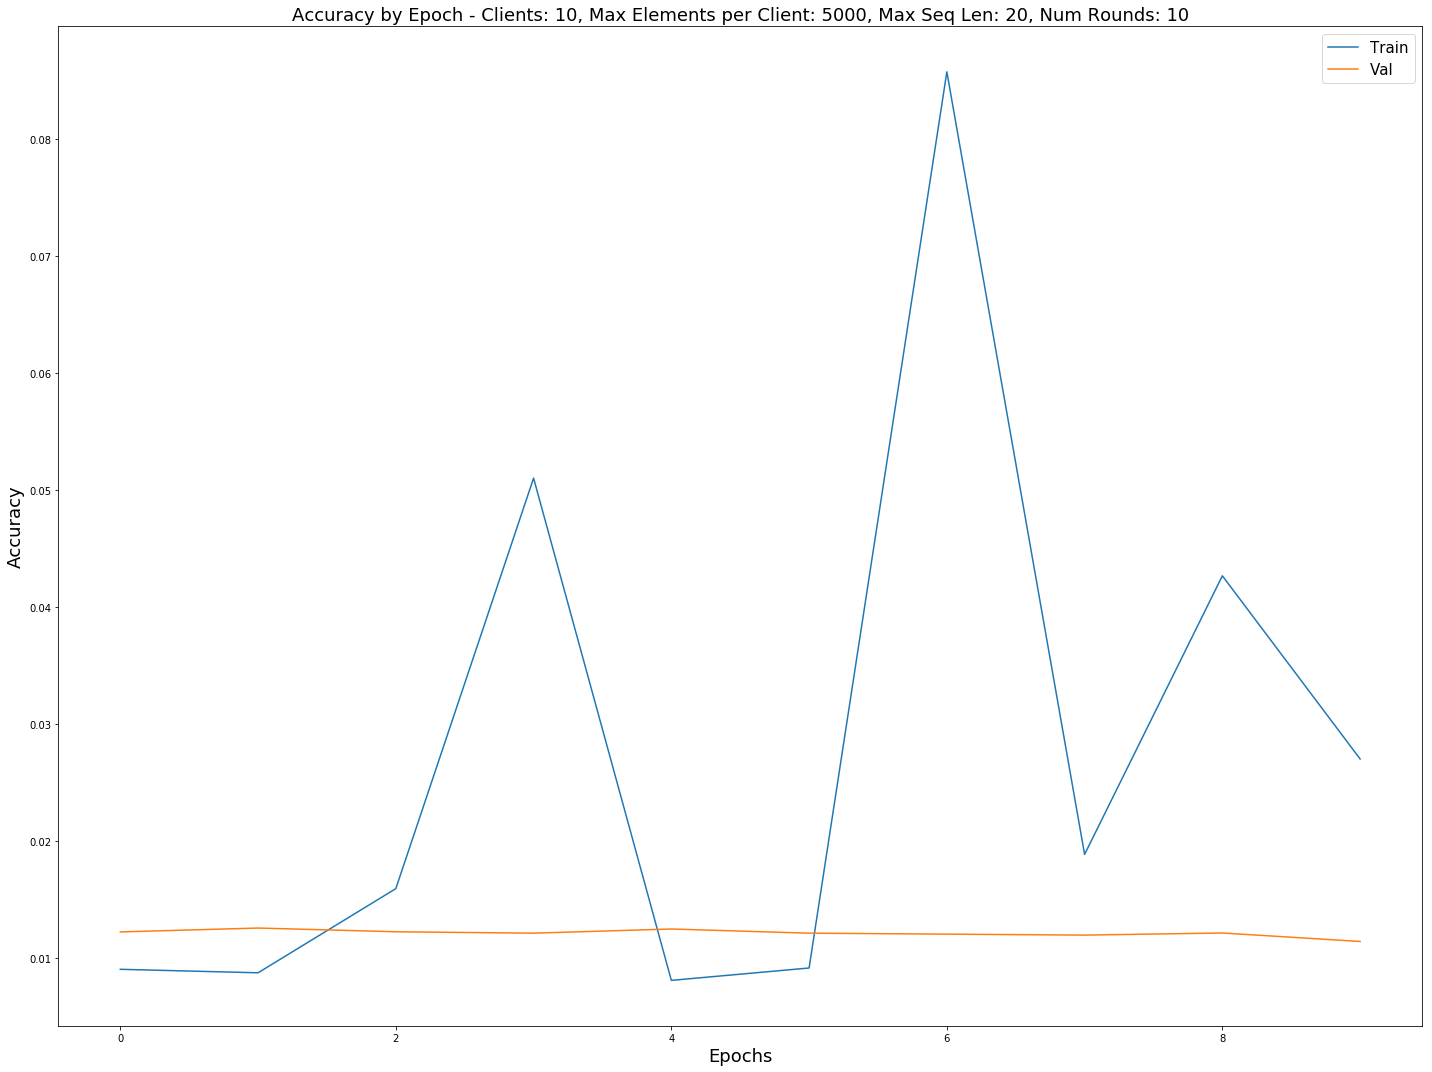

In [19]:
fig, ax = plt.subplots(figsize=(20, 15))
x_axis = range(0, NUM_ROUNDS)
ax.plot(x_axis, train_metrics_tracker.get_metrics_by_name('accuracy'), label='Train')
ax.plot(x_axis, val_metrics_tracker.get_metrics_by_name('accuracy'), label='Val')
ax.legend(loc='best', prop={'size': 15})
plt.title('Accuracy by Epoch - {}'.format(round_config), fontsize=18)
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Accuracy', fontsize=18)
plt.tight_layout()
plt.savefig(SAV + 'Accuracy by Epoch.png')
plt.show()